# **Email & SMS Spam Detection --- Machine Learning–powered application**

    This notebook demonstrates how to build a machine learning model that classifies email/SMS messages as Spam or Not Spam (Ham).

We will cover:

- Data loading,cleaning and preprocessing
- Text cleaning (tokenization, stopword removal, stemming)
- Feature extraction with TF-IDF
- Model training and evaluation
- Saving the trained model for deployment in a Streamlit web app

# *Let's Begin !*

## Importing Libraries
    We start by importing the necessary Python libraries for data manipulation, visualization, natural language processing, and machine learning.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords # stopwords don’t carry significant meaning, e.g: a, the, is, in, of, and etc
from nltk.stem.porter import PorterStemmer # stemming is the process of reducing a word to its root form
import string

!pip install wordcloud

from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import pickle

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package stopwords to C:\Users\SUJATA
[nltk_data]     SINHABABU\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Loading the Dataset

In [7]:
df=pd.read_csv("spam.csv", encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
df.shape

(5572, 5)

## Clean the Dataset

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [10]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [11]:
# drop the columns
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [12]:
# rename the columns
df.rename(columns={'v1':"Type",'v2':"Message"},inplace=True)

In [13]:
# check for duplicates values
df.duplicated().sum()

np.int64(403)

In [14]:
# remove duplicates
df=df.drop_duplicates()   #keep = first, by default

In [15]:
df.duplicated().sum()

np.int64(0)

In [16]:
df.shape

(5169, 2)

## Label Encoding

In [17]:
le=LabelEncoder()
df['Type']=le.fit_transform(df['Type'])

## Feature Engineering

In [18]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to C:\Users\SUJATA
[nltk_data]     SINHABABU\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [19]:
df['char_count']=df['Message'].apply(len)

In [20]:
# split message in words
df['Message'].apply(lambda x: nltk.word_tokenize(x))

0       [Go, until, jurong, point, ,, crazy, .., Avail...
1                [Ok, lar, ..., Joking, wif, u, oni, ...]
2       [Free, entry, in, 2, a, wkly, comp, to, win, F...
3       [U, dun, say, so, early, hor, ..., U, c, alrea...
4       [Nah, I, do, n't, think, he, goes, to, usf, ,,...
                              ...                        
5567    [This, is, the, 2nd, time, we, have, tried, 2,...
5568     [Will, Ì_, b, going, to, esplanade, fr, home, ?]
5569    [Pity, ,, *, was, in, mood, for, that, ., So, ...
5570    [The, guy, did, some, bitching, but, I, acted,...
5571                  [Rofl, ., Its, true, to, its, name]
Name: Message, Length: 5169, dtype: object

In [21]:
# count number of words
df['word_count']=df['Message'].apply(lambda x: len(nltk.word_tokenize(x)))

In [22]:
# split in sentence
df['Message'].apply(lambda x: nltk.sent_tokenize(x))

0       [Go until jurong point, crazy.., Available onl...
1                        [Ok lar..., Joking wif u oni...]
2       [Free entry in 2 a wkly comp to win FA Cup fin...
3       [U dun say so early hor... U c already then sa...
4       [Nah I don't think he goes to usf, he lives ar...
                              ...                        
5567    [This is the 2nd time we have tried 2 contact ...
5568              [Will Ì_ b going to esplanade fr home?]
5569    [Pity, * was in mood for that., So...any other...
5570    [The guy did some bitching but I acted like i'...
5571                        [Rofl., Its true to its name]
Name: Message, Length: 5169, dtype: object

In [23]:
# count no. of sentences
df['sent_count']= df['Message'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [24]:
df.head()

,Type,Message,char_count,word_count,sent_count
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [25]:
df[['char_count','word_count','sent_count']].describe()

,char_count,word_count,sent_count
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [26]:
# for ham messages
df[df['Type']==0][['char_count','word_count','sent_count']].describe()

,char_count,word_count,sent_count
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [27]:
# for spam messages
df[df['Type']==1][['char_count','word_count','sent_count']].describe()

,char_count,word_count,sent_count
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


- Spam messages are longer on average (almost double the characters).

- Spam message lengths are more concentrated (low std. dev), while ham varies widely (some very short, some very long).

## EDA

In [28]:
df.head()

,Type,Message,char_count,word_count,sent_count
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [29]:
df['Type'].value_counts()

Type
0    4516
1     653
Name: count, dtype: int64

### Visualize the percentage of ham and spam messages present in the dataset

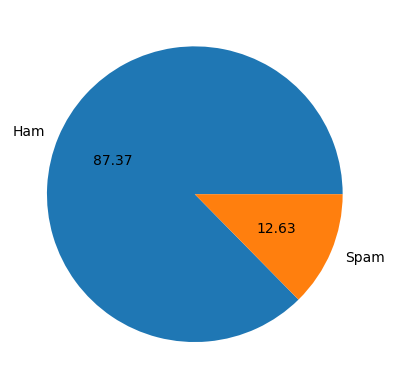

In [30]:
# Pie chart
plt.pie(df['Type'].value_counts(),labels=["Ham","Spam"],autopct="%.2f")
plt.show()

### Distribution of Character & Word Count by Message Type

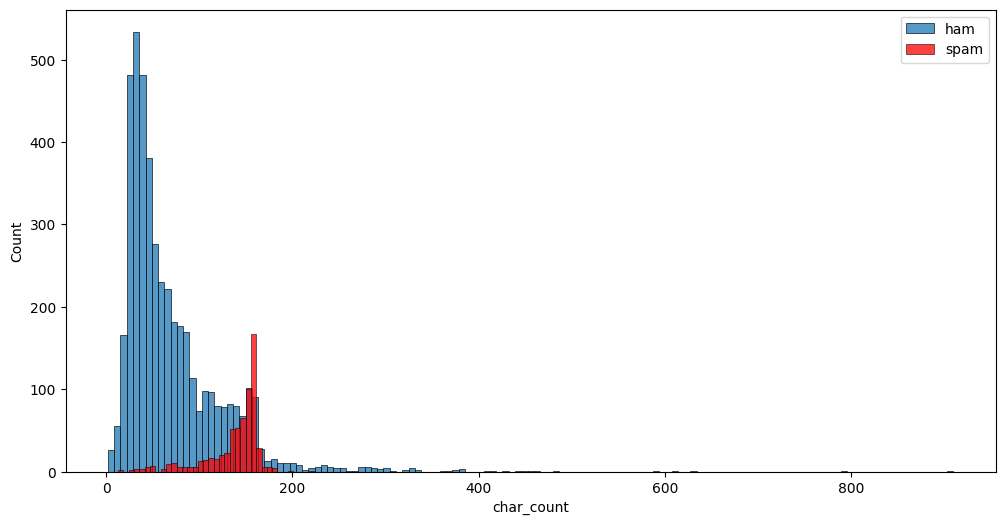

In [31]:
plt.figure(figsize=(12,6))

sns.histplot(df[df['Type']==0]['char_count'])#ham
sns.histplot(df[df['Type']==1]['char_count'],color='r')#spam

plt.legend(['ham','spam'])
plt.show()

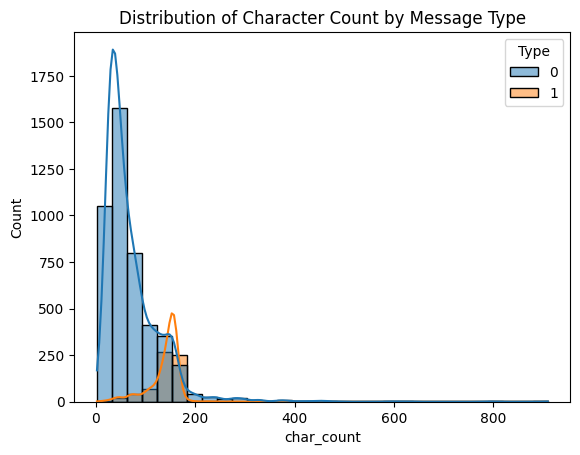

In [32]:
sns.histplot(data=df, x='char_count', hue='Type', bins=30, kde=True)
plt.title("Distribution of Character Count by Message Type")
plt.show()

- Spam has a narrower, concentrated character count, while ham shows greater variability.

- Ham messages (Type 0) are shorter, peaking around 30–80 characters.

- Spam messages (Type 1) are generally longer, with a peak between 130–160 characters.

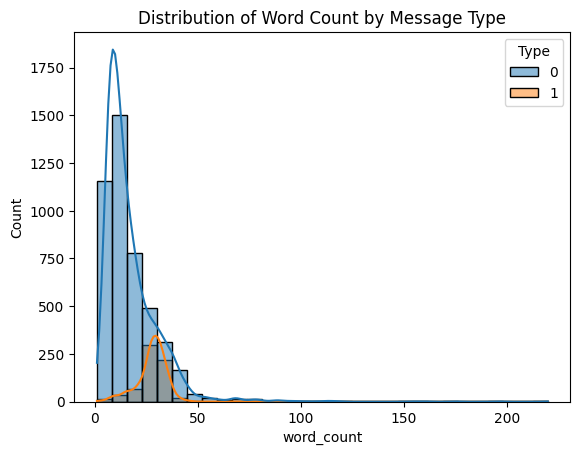

In [33]:
sns.histplot(data=df, x='word_count', hue='Type', bins=30, kde=True)
plt.title("Distribution of Word Count by Message Type")
plt.show()

- Spam messages typically contain more words (designed to convey promotions, fake urgency).

### Others plot to understand the data

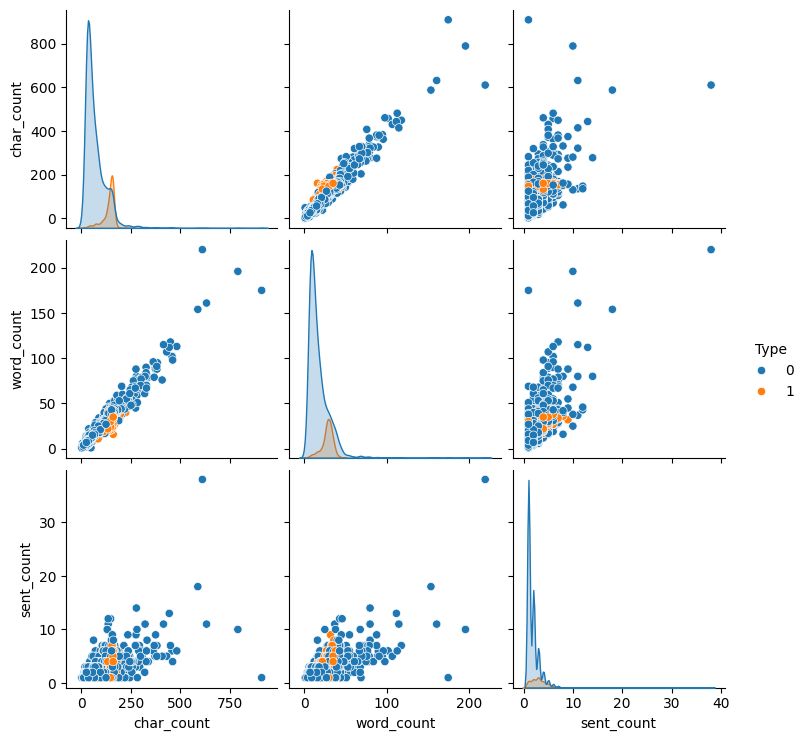

In [34]:
# pairplot
sns.pairplot(df,hue='Type')
plt.show()

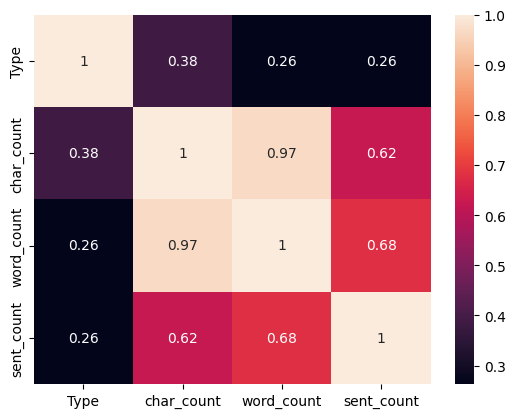

In [35]:
# heatmap
sns.heatmap(df[['Type','char_count','word_count','sent_count']].corr(),annot=True)
plt.show()

## Data Preprocessing
    Preprocessing is essential for text classification.

**Steps performed:**

- Lowercasing – convert all text to lowercase.
- Tokenization – split text into words.
- Stopwords & Punctuation Removal – remove irrelevant words and symbols.
- Stemming – reduce words to their root form (e.g., “running” → “run”).

In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\SUJATA
[nltk_data]     SINHABABU\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
def transform_text(text):
  text=text.lower() #convert in lower case

  text=nltk.word_tokenize(text) #tokenization of words


  #remove special characters, stopwords and punctuation

  y=[] #store cleaned characters
  for i in text:
    if i.isalnum(): #checks whether the character i is alphanumeric — meaning: Letters (A–Z, a–z),Digits (0–9)
      if i not in stopwords.words('english') and i not in string.punctuation: #check for stopwords and punctuation
        y.append(i)

  text=y[:]
  y.clear()

  ps= PorterStemmer()
  for i in text:
    y.append(ps.stem(i))

  return " ".join(y) #return as string

In [33]:
# # Example
transform_text('Hi! I loved to learn data science from youtube. How about you? Are you seeking for job?@20')

'hi love learn data scienc youtub seek job 20'

In [34]:
ps= PorterStemmer()
ps.stem('Going') #go

'go'

In [35]:
string.punctuation        #!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [36]:
stopwords.words('english')

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [37]:
df["trans_msg"]=df['Message'].apply(transform_text)

In [38]:
df.head()

,Type,Message,char_count,word_count,sent_count,trans_msg
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


## Top Words
    Identify the most frequently used words in spam and ham messages/email.

In [41]:
from wordcloud import WordCloud # to find most uses or important words
wc=WordCloud(width=1000,height=1000,min_font_size=10,background_color='white')

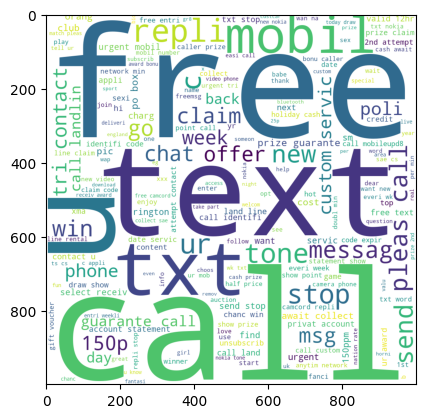

In [42]:
spam_wc=wc.generate(df[df['Type']==1]['trans_msg'].str.cat(sep=" ")) # for spam msg
plt.imshow(spam_wc)

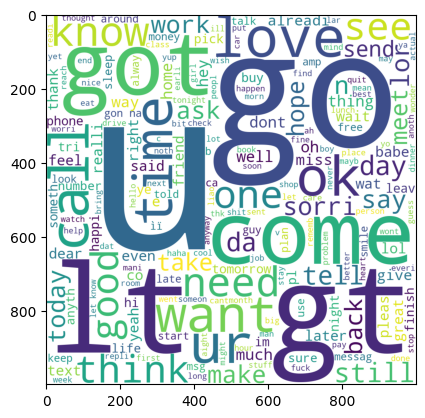

In [43]:
ham_wc=wc.generate(df[df['Type']==0]['trans_msg'].str.cat(sep=" ")) # for ham msg
plt.imshow(ham_wc)

In [44]:
# top 30 words for spam
spam_words=[]
for msg in df[df['Type']==1]['trans_msg'].tolist():
  for word in msg.split():
    spam_words.append(word)

len(spam_words)

9939

In [45]:
from collections import Counter
Counter(spam_words).most_common(30)

[('call', 320),
 ('free', 191),
 ('2', 155),
 ('txt', 141),
 ('text', 122),
 ('u', 119),
 ('ur', 119),
 ('mobil', 114),
 ('stop', 104),
 ('repli', 103),
 ('claim', 98),
 ('4', 97),
 ('prize', 82),
 ('get', 74),
 ('new', 64),
 ('servic', 64),
 ('tone', 63),
 ('send', 60),
 ('urgent', 57),
 ('nokia', 57),
 ('contact', 56),
 ('award', 55),
 ('phone', 52),
 ('cash', 51),
 ('pleas', 51),
 ('week', 49),
 ('win', 48),
 ('c', 45),
 ('collect', 45),
 ('min', 45)]

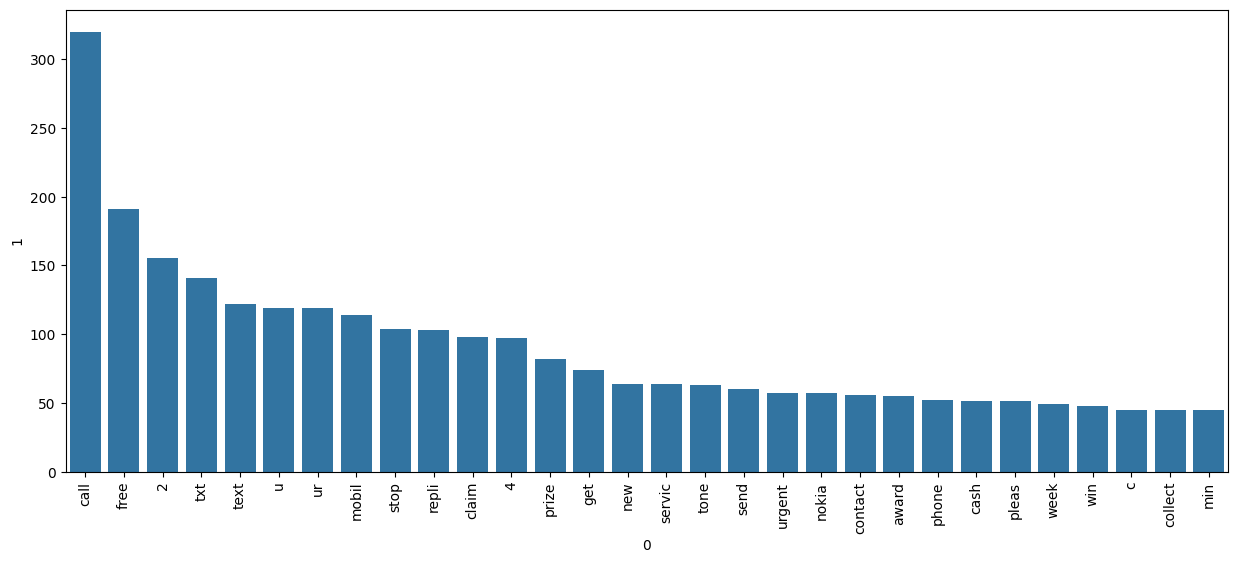

In [46]:
spam_words_df= pd.DataFrame(Counter(spam_words).most_common(30))

plt.figure(figsize=(15,6))
sns.barplot(x=spam_words_df[0],y=spam_words_df[1])
plt.xticks(rotation='vertical')
plt.show()

In [47]:
# top 30 words for spam
ham_words=[]
for msg in df[df['Type']==0]['trans_msg'].tolist():
  for word in msg.split():
    ham_words.append(word)

len(ham_words)

35404

In [48]:
Counter(ham_words).most_common(30)

[('u', 883),
 ('go', 404),
 ('get', 349),
 ('gt', 288),
 ('lt', 287),
 ('2', 284),
 ('come', 275),
 ('got', 236),
 ('know', 236),
 ('like', 234),
 ('call', 233),
 ('time', 219),
 ('ok', 217),
 ('love', 216),
 ('good', 213),
 ('want', 208),
 ('ur', 197),
 ('day', 190),
 ('need', 170),
 ('one', 165),
 ('lor', 159),
 ('4', 156),
 ('home', 152),
 ('think', 149),
 ('see', 147),
 ('take', 143),
 ('still', 143),
 ('da', 142),
 ('tell', 133),
 ('make', 129)]

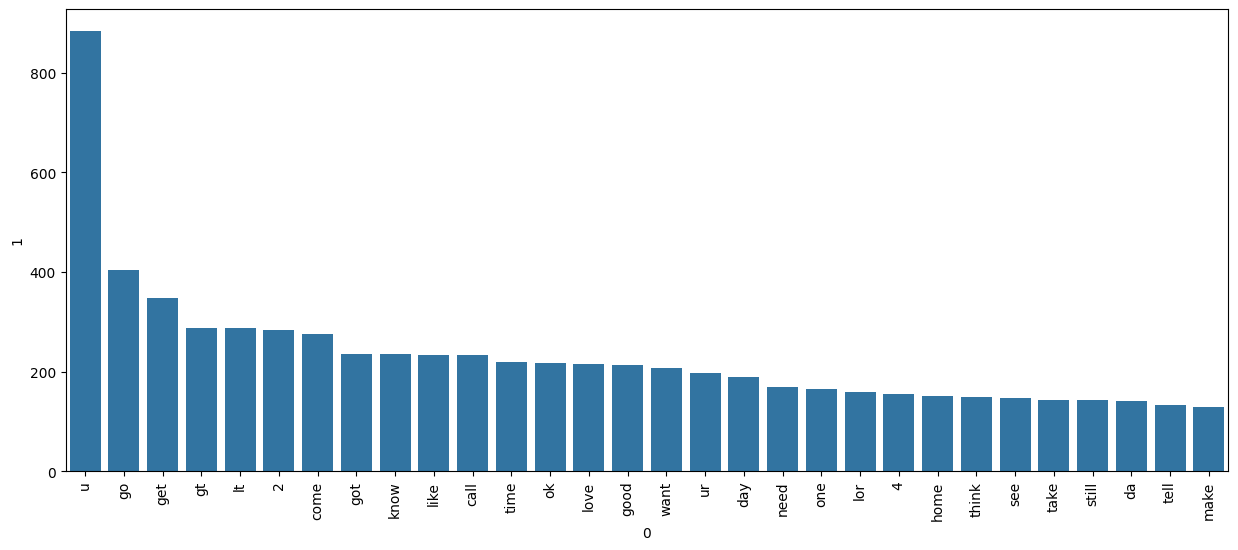

In [49]:
ham_words_df= pd.DataFrame(Counter(ham_words).most_common(30))

plt.figure(figsize=(15,6))
sns.barplot(x=ham_words_df[0],y=ham_words_df[1])
plt.xticks(rotation='vertical')
plt.show()

## Text Vectorization
- Convert text into numerical features using TF-IDF (Term Frequency – Inverse Document Frequency).
- Each message is represented as a vector that captures the importance of words.

In [50]:
df.head()

,Type,Message,char_count,word_count,sent_count,trans_msg
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [51]:
tfid= TfidfVectorizer(max_features=3000)

In [52]:
X=tfid.fit_transform(df['trans_msg']).toarray()
X.shape

(5169, 3000)

In [53]:
y=df['Type'].values
y

array([0, 0, 1, ..., 0, 0, 0], shape=(5169,))

## Train-Test Split

In [54]:
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2,random_state=2)

## Model Training and Evolution
    We experiment with different classification algorithms and evaluate models using accuracy, precision, recall, and F1-score.
    Compare performance metrics and select the best model.


In [55]:
lr= LogisticRegression()
svc= SVC(kernel='sigmoid',gamma=1.0)
knn= KNeighborsClassifier()
dt= DecisionTreeClassifier(max_depth=5)
rf=RandomForestClassifier(n_estimators=50)
mnb= MultinomialNB()
ada=AdaBoostClassifier(n_estimators=50)
bg=BaggingClassifier(n_estimators=50)
exc=ExtraTreesClassifier(n_estimators=50)
gbc=GradientBoostingClassifier(n_estimators=50)
xgb= XGBClassifier(n_estimators=50)
lgbm=LGBMClassifier(verbosity=-1)

In [56]:
models={
    'Logistic Regression':lr,
    'SVC':svc,
    'KNN':knn,
    'Decision Tree':dt,
    'Random Forest':rf,
    'Naive Bayes':mnb,
    'AdaBoost':ada,
    'Bagging':bg,
    'ExtraTrees':exc,
    'GradientBoosting':gbc,
    'XGB':xgb,
    'LGBM':lgbm
}

In [57]:
def evaluate_model(name, model, X_test, y_test):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  scores = {
      "Model": name,
      "Accuracy": accuracy_score(y_test, y_pred)*100,
      "Precision": precision_score(y_test, y_pred)*100,
      "Recall ": recall_score(y_test, y_pred)*100,
      "F1": f1_score(y_test, y_pred)*100
  }

  return scores

In [62]:
model_scores=[]
for name, model in models.items():
    score = evaluate_model(name, model, X_test, y_test)
    model_scores.append(score)

C:\Users\SUJATA SINHABABU\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [59]:
model_scores = pd.DataFrame(model_scores).round(4)
model_scores= model_scores.sort_values(by='Precision', ascending=False)
model_scores

,Model,Accuracy,Precision,Recall,F1
2,KNN,90.5222,100.0000,28.9855,44.9438
4,Random Forest,97.6789,100.0000,82.6087,90.4762
5,Naive Bayes,97.0986,100.0000,78.2609,87.8049
0,Logistic Regression,95.4545,97.8947,67.3913,79.8283
8,ExtraTrees,97.7756,97.5207,85.5072,91.1197
1,SVC,97.5822,97.4790,84.0580,90.2724
10,XGB,96.8085,94.8718,80.4348,87.0588
9,GradientBoosting,95.1644,94.0000,68.1159,78.9916
11,LGBM,97.0019,90.8397,86.2319,88.4758
3,Decision Tree,93.4236,85.0000,61.5942,71.4286


- Overall balanced model is **Random Forest**	with Accuracy-97.67895% & Precision	- 100%

In [60]:
model_scores = model_scores.reset_index()
plot_data = model_scores.melt(
    id_vars="Model",
    value_vars=["Accuracy","Precision"],
    var_name="Metric",
    value_name="Score"
)
plot_data

,Model,Metric,Score
0,KNN,Accuracy,90.5222
1,Random Forest,Accuracy,97.6789
2,Naive Bayes,Accuracy,97.0986
3,Logistic Regression,Accuracy,95.4545
4,ExtraTrees,Accuracy,97.7756
5,SVC,Accuracy,97.5822
6,XGB,Accuracy,96.8085
7,GradientBoosting,Accuracy,95.1644
8,LGBM,Accuracy,97.0019
9,Decision Tree,Accuracy,93.4236


<Figure size 1200x1600 with 0 Axes>

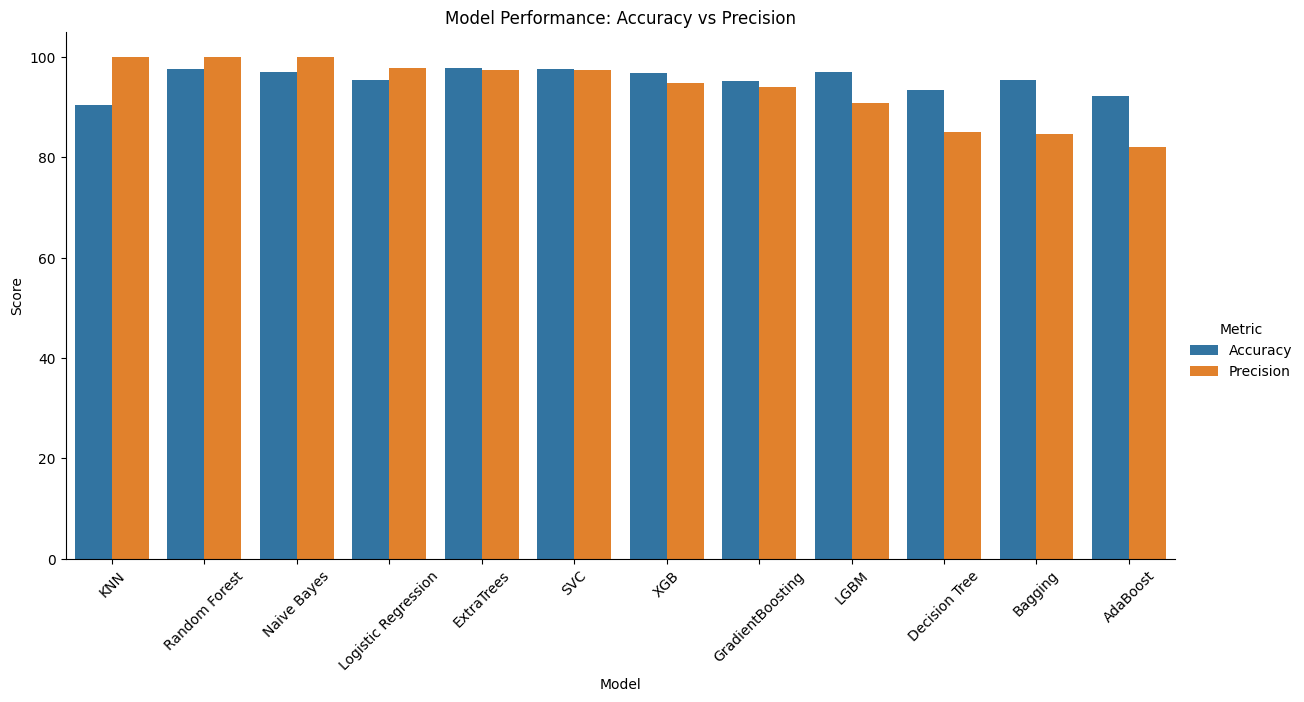

In [61]:
plt.figure(figsize=(12,16))
sns.catplot(x="Model", y="Score", hue="Metric", kind="bar", data=plot_data, height=6, aspect=2)
plt.title("Model Performance: Accuracy vs Precision")
plt.xticks(rotation=45)
plt.show()

## Save the Vectorizer and Best Model

In [63]:
import pickle

In [64]:
pickle.dump(rf, open("spam_model.pkl","wb"))
pickle.dump(tfid, open("vectorizer.pkl","wb"))


# Conclusion
- Built a robust spam classification system using machine learning.
- Achieved high accuracy and reliability in detecting spam.
- Prepared the model for deployment with a user-friendly interface.

# Future Scope

- Try Deep Learning models (LSTMs, Transformers) for improved performance.
- Expand dataset with multilingual spam detection.
- Add real-world features like sender info, subject lines, or metadata.